In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [4]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/classification_of_reviews/wb_reviews.csv"

data = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
data['Rating'] = data['Rating'].apply(lambda x: x*2)

In [7]:
data['Sentiment'] = data['Rating'].apply(lambda x: 1 if x >= 7 else 0)

In [14]:
data = data.dropna()

In [15]:
data

,Good's name,Description,Review,Rating,Sentiment
0,Мочалка для душа Grizzly XXL для тела черная,Готовы к незабываемым впечатлениям в душе? «Gr...,Хорошо моет,10,1
1,Мочалка для душа Grizzly XXL для тела черная,Готовы к незабываемым впечатлениям в душе? «Gr...,"При первом использовании заметил ,что мочалка ...",2,0
2,Мочалка для душа Grizzly XXL для тела черная,Готовы к незабываемым впечатлениям в душе? «Gr...,Супер всё!,10,1
3,Мочалка для душа Grizzly XXL для тела черная,Готовы к незабываемым впечатлениям в душе? «Gr...,"Пошита, на первый взгляд, не плохо. Мылится не...",10,1
4,Мочалка для душа Grizzly XXL для тела черная,Готовы к незабываемым впечатлениям в душе? «Gr...,Слишком мягкая,2,0
...,...,...,...,...,...
196940,Звонок дверной беспроводной на батарейках,Звонок дверной беспроводной влагозащищенный ул...,Прекрасный звонок. У нас получилась дальность ...,10,1
196941,Звонок дверной беспроводной на батарейках,Звонок дверной беспроводной влагозащищенный ул...,Всё супер. Звонок просто ВАУУУ,10,1
196942,Звонок дверной беспроводной на батарейках,Звонок дверной беспроводной влагозащищенный ул...,"Классный звонок, сколько у нас из было,этот са...",10,1
196943,Звонок дверной беспроводной на батарейках,Звонок дверной беспроводной влагозащищенный ул...,"Звенит звонко Нет Очень хороший звоночек, мн...",10,1


Отзыв будет считаться положительным, если его оценка неменьше 7-ми.

Для начала обучим логистическую регрессию на «грязных» данных, но сразу будем использовать tf-idf.

## 1. Logreg без очистки

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['Review']],
                                                    data['Sentiment'],
                                                    stratify=data['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

In [17]:
X_train.shape, X_test.shape

((143769, 1), (47923, 1))

In [18]:
raw_logreg = Pipeline([
    ('tf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

In [19]:
raw_logreg.fit(X_train['Review'], y_train)

Pipeline(steps=[('tf', TfidfVectorizer()),
                ('clf', LogisticRegression(random_state=42))])

In [20]:
pred = raw_logreg.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.79      0.56      0.65      6680
           1       0.93      0.98      0.95     41243

    accuracy                           0.92     47923
   macro avg       0.86      0.77      0.80     47923
weighted avg       0.91      0.92      0.91     47923



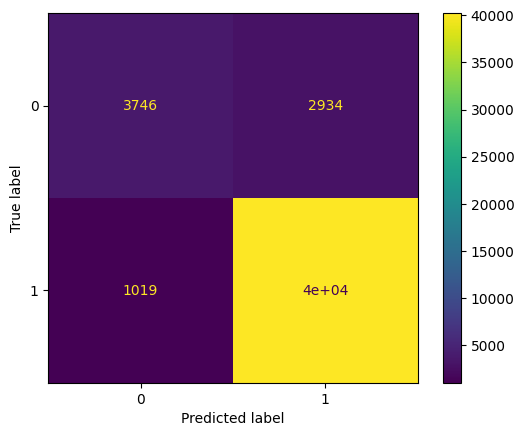

In [21]:
_ = ConfusionMatrixDisplay.from_estimator(raw_logreg, X_test['Review'], y_test)

## 2. Logreg с предобработкой (стеммер)

In [22]:
data_clean = data.copy()

In [23]:
def count_russian_chars(s: str) -> int:
    return len(re.findall(r'[а-яА-Я]', s))

data_clean['Russian chars'] = data_clean['Review'].apply(count_russian_chars)

In [24]:
data_clean_russian = data_clean[data_clean['Russian chars'] > 0]
data_clean_russian = data_clean_russian.reset_index(drop=True)

In [25]:
nltk.download('punkt')
nltk.download('punkt_tab')

stemmer = SnowballStemmer("russian")

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text, language="russian")
    words = [stemmer.stem(word) for word in words]
    return " ".join(words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [26]:
data_clean_russian['Review'] = data_clean_russian['Review'].apply(lambda x: preprocess_text(str(x)))

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_clean_russian[['Review']],
                                                    data_clean_russian['Sentiment'],
                                                    stratify=data_clean_russian['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

In [28]:
pipeline = Pipeline([
    ('tf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

In [29]:
pipeline.fit(X_train['Review'], y_train)

Pipeline(steps=[('tf', TfidfVectorizer()),
                ('clf', LogisticRegression(random_state=42))])

In [30]:
pred = pipeline.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.76      0.60      0.67      6675
           1       0.94      0.97      0.95     40744

    accuracy                           0.92     47419
   macro avg       0.85      0.78      0.81     47419
weighted avg       0.91      0.92      0.91     47419



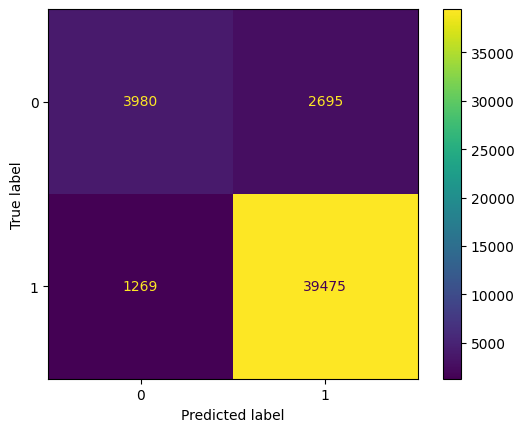

In [31]:
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test['Review'], y_test)

## 3. Logreg с предобработкой (стеммер) и подбором гиперпараметров (для tf-idf тоже)

In [32]:
pipeline = Pipeline([
    ('tf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

param_grid = {
    'tf__ngram_range': [(1, 1), (1, 2)], # Важно посмотреть хотя бы на биграммах тоже
    'tf__max_features': [500, 1000, None],
    'clf__C': [0.1, 1, 10],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='precision', n_jobs=-1)

In [33]:
grid_search.fit(X_train['Review'], y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'tf__max_features': [500, 1000, None],
                         'tf__ngram_range': [(1, 1), (1, 2)]},
             scoring='precision')

In [34]:
print("Best parameters:", grid_search.best_params_)
best_clf = grid_search.best_estimator_

Best parameters: {'clf__C': 10, 'tf__max_features': None, 'tf__ngram_range': (1, 2)}


In [35]:
pred = best_clf.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.79      0.70      0.74      6675
           1       0.95      0.97      0.96     40744

    accuracy                           0.93     47419
   macro avg       0.87      0.84      0.85     47419
weighted avg       0.93      0.93      0.93     47419



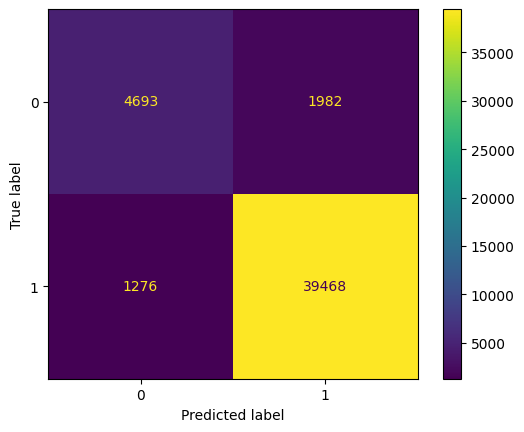

In [36]:
_ = ConfusionMatrixDisplay.from_estimator(best_clf, X_test['Review'], y_test)

## 4. Logreg с предобработкой (стеммер + стопслова)

In [37]:
data_clean = data.copy()

In [38]:
def count_russian_chars(s: str) -> int:
    return len(re.findall(r'[а-яА-Я]', s))

data_clean['Russian chars'] = data_clean['Review'].apply(count_russian_chars)

In [39]:
data_clean_russian = data_clean[data_clean['Russian chars'] > 0]
data_clean_russian = data_clean_russian.reset_index(drop=True)

In [40]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stemmer = SnowballStemmer("russian")
stop_words = set(stopwords.words("russian"))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text, language="russian")
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [41]:
data_clean_russian['Review'] = data_clean_russian['Review'].apply(lambda x: preprocess_text(str(x)))

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_clean_russian[['Review']],
                                                    data_clean_russian['Sentiment'],
                                                    stratify=data_clean_russian['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

In [43]:
pipeline_2 = Pipeline([
    ('tf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

In [44]:
pipeline_2.fit(X_train['Review'], y_train)

Pipeline(steps=[('tf', TfidfVectorizer()),
                ('clf', LogisticRegression(random_state=42))])

In [45]:
pred = pipeline_2.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.77      0.54      0.64      6675
           1       0.93      0.97      0.95     40744

    accuracy                           0.91     47419
   macro avg       0.85      0.76      0.79     47419
weighted avg       0.91      0.91      0.91     47419



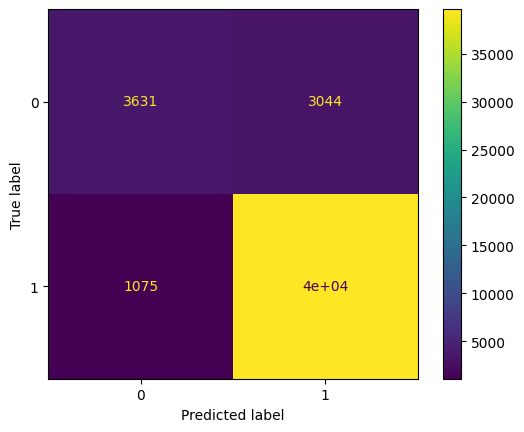

In [46]:
_ = ConfusionMatrixDisplay.from_estimator(pipeline_2, X_test['Review'], y_test)

## 5. Logreg с предобработкой (стеммер + стопслова) и подбором гиперпараметров (для tf-idf тоже)

In [47]:
pipeline = Pipeline([
    ('tf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

param_grid = {
    'tf__ngram_range': [(1, 1), (1, 2)], # Важно посмотреть хотя бы на биграммах тоже
    'tf__max_features': [500, 1000, None],
    'clf__C': [0.1, 1, 10],
}

grid_search_2 = GridSearchCV(pipeline, param_grid, cv=3, scoring='precision', n_jobs=-1)

In [48]:
grid_search_2.fit(X_train['Review'], y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'tf__max_features': [500, 1000, None],
                         'tf__ngram_range': [(1, 1), (1, 2)]},
             scoring='precision')

In [49]:
print("Best parameters:", grid_search_2.best_params_)
best_clf_2 = grid_search_2.best_estimator_

Best parameters: {'clf__C': 10, 'tf__max_features': None, 'tf__ngram_range': (1, 2)}


In [50]:
pred = best_clf_2.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.75      0.63      0.68      6675
           1       0.94      0.96      0.95     40744

    accuracy                           0.92     47419
   macro avg       0.84      0.80      0.82     47419
weighted avg       0.91      0.92      0.91     47419



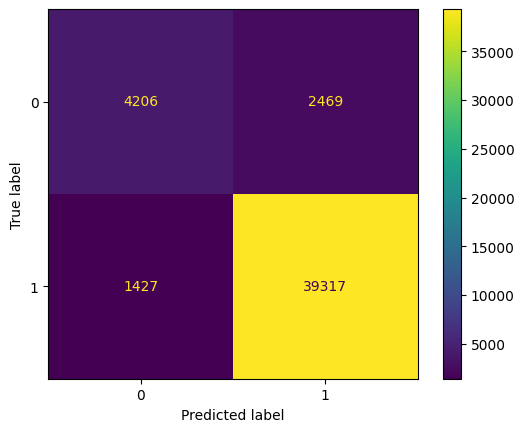

In [51]:
_ = ConfusionMatrixDisplay.from_estimator(best_clf_2, X_test['Review'], y_test)

# Вывод

## 1. Logreg без тюнинга
Базовая модель логистической регрессии без дополнительной предобработки текста и подбора гиперпараметров.
### Результаты:
*   Класс 0 (негативные): Precision=0.79, Recall=0.56, F1=0.65
*   Класс 1 (позитивные): Precision=0.93, Recall=0.98, F1=0.95
*   Accuracy: 0.92

Модель демонстрирует хорошие результаты для позитивных отзывов (F1=0.95), но относительно низкий recall для негативных (0.56), что означает пропуск 44% негативных отзывов.

## 2. Logreg с предобработкой (стеммер)
Добавлена предобработка текста с использованием стемминга.
### Результаты:
*   Класс 0 (негативные): Precision=0.76 (-0.03), Recall=0.60 (+0.04), F1=0.67 (+0.02)
*   Класс 1 (позитивные): Precision=0.94 (+0.01), Recall=0.97 (-0.01), F1=0.95 (=)
*   Accuracy: 0.92 (=)

Стемминг улучшил recall для негативных отзывов на 4% и F1-score на 2%, хотя precision незначительно снизился. Общая точность осталась прежней.

## 3. Logreg с предобработкой (стеммер) и подбором гиперпараметров (для tf-idf тоже)
Добавлен подбор гиперпараметров для модели и TF-IDF.
### Результаты:
*   Класс 0 (негативные): Precision=0.79 (+0.03), Recall=0.70 (+0.14), F1=0.74 (+0.09)
*   Класс 1 (позитивные): Precision=0.95 (+0.01), Recall=0.97 (=), F1=0.96 (+0.01)
*   Accuracy: 0.93 (+0.01)

Подбор параметров дал значительное улучшение: recall для негативных отзывов вырос на 14%, F1-score - на 9%. Также улучшились метрики для позитивного класса.

## 4. Logreg с предобработкой (стеммер + стопслова)
Добавлено удаление стоп-слов к предобработке.
### Результаты:
*   Класс 0 (негативные): Precision=0.77 (-0.02), Recall=0.54 (-0.06), F1=0.64 (-0.03)
*   Класс 1 (позитивные): Precision=0.93 (-0.01), Recall=0.97 (=), F1=0.95 (=)
*   Accuracy: 0.91 (-0.01)

Удаление стоп-слов ухудшило основные метрики для негативных отзывов, особенно recall (-6%). Общая точность также снизилась.

## 5. Logreg с предобработкой (стеммер + стопслова) и подбором гиперпараметров (для tf-idf тоже)
Комбинация стемминга, удаления стоп-слов и подбора гиперпараметров.
### Результаты:
*   Класс 0 (негативные): Precision=0.75 (-0.04), Recall=0.63 (+0.07), F1=0.68 (+0.03)
*   Класс 1 (позитивные): Precision=0.94 (+0.01), Recall=0.96 (-0.01), F1=0.95 (=)
*   Accuracy: 0.92 (+0.01)

Хотя тюнинг улучшил метрики по сравнению с версией без него, эта конфигурация уступает чистому стеммингу с тюнингом (Эксперимент 3).

## Итог
### Лучшая конфигурация
Эксперимент 3 (стемминг + подбор гиперпараметров) показал наилучшие результаты:
*   Максимальный F1-score для негативных отзывов (0.74)
*   Наибольший recall для класса 0 (0.70)
*   Улучшенные метрики для обоих классов
*   Наивысшая общая accuracy (0.93)
